In [1]:
import os
import json
import yaml
import time
import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Load environment variables (API key)
load_dotenv()
client = OpenAI()

In [2]:
# === Configuration ===
GEN_MODEL = "gpt-3.5-turbo"
JUDGE_MODEL = "gpt-4o"
TEMPERATURE = 0
N_SAMPLES = 3  # Number of samples per condition
BASELINE = "baseline_cot.hierarchical_structure"

In [29]:
PATTERNS = [
    # 의사결정 패턴
    "decision_making.hierarchical_structure",
    "decision_making.multiple_perspective",
    "decision_making.self_reflective",

    # 윤리적 추론 패턴
    "ethical_reasoning.hierarchical_structure",
    "ethical_reasoning.multiple_perspective",
    "ethical_reasoning.self_reflective",

    # 창의적 사고 패턴
    "creative_thinking.hierarchical_structure",
    "creative_thinking.multiple_perspective",
    "creative_thinking.self_reflective",

    # 가설적 시나리오 분석 패턴
    "hypothetical_scenario.hierarchical_structure",
    "hypothetical_scenario.multiple_perspective",
    "hypothetical_scenario.self_reflective",
]

In [30]:
SCENARIOS = {
    "decision": "Develop a strategy for entering a new business market.",
    "ethics": "Resolve the ethical dilemma of self-driving cars.",
    "creative": "Propose innovative ways to utilize urban spaces.",
    "scenario": "Predict the long-term effects of climate change."
}

In [31]:
# === Load YAML Prompt Templates ===
with open("templates.yaml", encoding="utf-8") as f:
    TEMPLATES = yaml.safe_load(f)

In [32]:
def get_template(path: str) -> str:
    node = TEMPLATES
    for key in path.split("."):
        if key not in node:
            raise KeyError(f"Invalid template path: {path}")
        node = node[key]
    return node

In [33]:
def render_template(path: str, scenario: str, depth=5, detail=5, priorities="-") -> str:
    block = get_template(path)
    if isinstance(block, dict):
        block = block.get("meta_level", "") + block.get("structure_level", "") + block.get("content_level", "")
    return (block.replace("${scenario}", scenario)
                 .replace("${depth}", str(depth))
                 .replace("${detail}", str(detail))
                 .replace("${priorities}", priorities))

In [ ]:
def gpt_call(model: str, prompt: str, system_prompt: str = "", retries=3) -> str:
    messages = [{"role": "system", "content": system_prompt}] if system_prompt else []
    messages.append({"role": "user", "content": prompt})

    for attempt in range(retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                temperature=TEMPERATURE,
                messages=messages,
                timeout=60
            )
            return resp.choices[0].message.content.strip()
        except Exception as e:
            print(f" GPT call failed (attempt {attempt + 1}): {e}")
            time.sleep(3)
    return ""

In [35]:
def judge_pairwise(resp_a: str, resp_b: str) -> dict:
    judge_prompt = f"""
Criteria: logic, diversity, metacognition, and stepwise thinking (each scored 1–5).
Return JSON format: {{"better": "A/B", "logic": x, "diversity": x, "meta": x, "step": x}}

Response A:
{resp_a}

Response B:
{resp_b}
"""
    response = gpt_call(JUDGE_MODEL, judge_prompt, system_prompt="You are a strict evaluator. Output valid JSON only.")
    
    # 🔧 JSON 정리: 코드블럭 제거
    response = re.sub(r"```json|```", "", response).strip()
    
    try:
        return json.loads(response)
    except json.JSONDecodeError:
        print("⚠️ Invalid JSON from judge (after cleanup):\n", response[:300])
        return {"better": "-", "logic": 0, "diversity": 0, "meta": 0, "step": 0}

In [ ]:
def run_evaluation():
    pairwise_records = []

    for s_key, s_text in SCENARIOS.items():
        for pat_path in PATTERNS:
            for i in range(N_SAMPLES):
                try:
                    base_prompt = render_template(BASELINE, s_text)
                    pat_prompt = render_template(pat_path, s_text)

                    resp_base = gpt_call(GEN_MODEL, base_prompt)
                    resp_pat = gpt_call(GEN_MODEL, pat_prompt)

                    judge_result = judge_pairwise(resp_base, resp_pat)
                    pairwise_records.append({
                        "scenario": s_key,
                        "pattern": pat_path,
                        "A_name": BASELINE,
                        "B_name": pat_path,
                        "A_output": resp_base,
                        "B_output": resp_pat,
                        "better": judge_result.get("better", "-"),
                        "logic": judge_result.get("logic", 0),
                        "diversity": judge_result.get("diversity", 0),
                        "meta": judge_result.get("meta", 0),
                        "step": judge_result.get("step", 0)
                    })

                    time.sleep(2)  # Respect rate limits
                except KeyError as e:
                    print(f" Skipping invalid pattern: {pat_path} -> {e}")

    # Save results
    os.makedirs("results", exist_ok=True)
    pd.DataFrame(pairwise_records).to_csv("results/pairwise_judgment.csv", index=False)
    print("✓ Pairwise evaluation complete. Saved to `results/pairwise_judgment.csv`")

In [37]:
# Run
run_evaluation()

✓ Pairwise evaluation complete. Saved to `results/pairwise_judgment.csv`


In [12]:
# === Visualization (Baseline vs. Patterns) ===
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [13]:
# 데이터 로드
df = pd.read_csv("results/pairwise_judgment.csv")

In [14]:
# 평가 기준
criteria = ["logic", "diversity", "meta", "step"]

In [15]:
# A: baseline / B: pattern
baseline_scores = df.groupby("B_name")[criteria].mean().reset_index()
baseline_scores = baseline_scores.rename(columns={"B_name": "pattern"})

In [16]:
# baseline 기준점 계산
base_only = df[df["B_name"] == "baseline_cot.hierarchical_structure"]
base_mean = base_only[criteria].mean()

In [17]:
# 차이 계산
for col in criteria:
    baseline_scores[col + "_delta"] = baseline_scores[col] - base_mean[col]

In [18]:
# 시각화: 각 기준별로 score 차이 시각화
melted = baseline_scores.melt(id_vars="pattern", 
                              value_vars=[c + "_delta" for c in criteria],
                              var_name="criterion", value_name="score_diff")

In [19]:
# 기준 이름 깔끔하게
melted["criterion"] = melted["criterion"].str.replace("_delta", "").str.capitalize()

In [ ]:
print("✓ Baseline comparison visualization complete. Saved to `results/evaluation_diff_chart.png`")

✓ Baseline comparison visualization complete. Saved to `results/evaluation_diff_chart.png`


In [ ]:
# 전체 평가 점수 평균 보기
avg_all = df.groupby("B_name")[["logic", "diversity", "meta", "step"]].mean()
avg_baseline = df[df["A_name"] == BASELINE][["logic", "diversity", "meta", "step"]].mean()

# 합쳐서 비교 테이블 만들기
comparison = avg_all.copy()
comparison.loc["baseline"] = avg_baseline
comparison = comparison.round(2).sort_index()

print("🔎 Average Evaluation Scores Comparison")
print(comparison)


🔎 Average Evaluation Scores Comparison
                                        logic  diversity  meta  step
B_name                                                              
baseline                                  5.0       4.33   5.0   5.0
decision_making.hierarchical_structure    5.0       4.33   5.0   5.0


In [27]:
# 점수 정렬된 테이블 출력
avg_scores_all = merged.groupby("pattern")[score_cols].mean().reset_index().round(2)
ranked = avg_scores_all.copy()
ranked["Total Avg"] = ranked[score_cols].mean(axis=1).round(2)
ranked = ranked.sort_values("Total Avg", ascending=False)

print("🔢 Prompt Pattern Ranking (Including Baseline):")
print(ranked)


🔢 Prompt Pattern Ranking (Including Baseline):
                                  pattern  logic  diversity  meta  step  \
0     baseline_cot.hierarchical_structure    5.0       4.33   5.0   5.0   
1  decision_making.hierarchical_structure    5.0       4.33   5.0   5.0   

   Total Avg  
0       4.83  
1       4.83  


In [45]:
top_pattern = pattern_winrate.sort_values("win_rate", ascending=False).iloc[0]
summary = f"""
가장 성능이 우수한 패턴은 '{top_pattern['pattern']}'으로, baseline 대비 평균 {top_pattern['win_rate']}%의 우위를 보였습니다.
이 패턴은 특히 구조적 사고 유도를 통해 논리성과 단계성 측면에서 큰 향상을 이끌어냈습니다.
"""
print(summary)



가장 성능이 우수한 패턴은 'creative_thinking.hierarchical_structure'으로, baseline 대비 평균 100.0%의 우위를 보였습니다.
이 패턴은 특히 구조적 사고 유도를 통해 논리성과 단계성 측면에서 큰 향상을 이끌어냈습니다.



C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1361346612.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(win_summary["pattern"], rotation=45, ha="right")
C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1361346612.py:60: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1361346612.py:60: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1361346612.py:63: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.savefig(save_path)
C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1361346612.py:63: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.savefig(save_path)
e:\KIICE\thought_simulator\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Gly

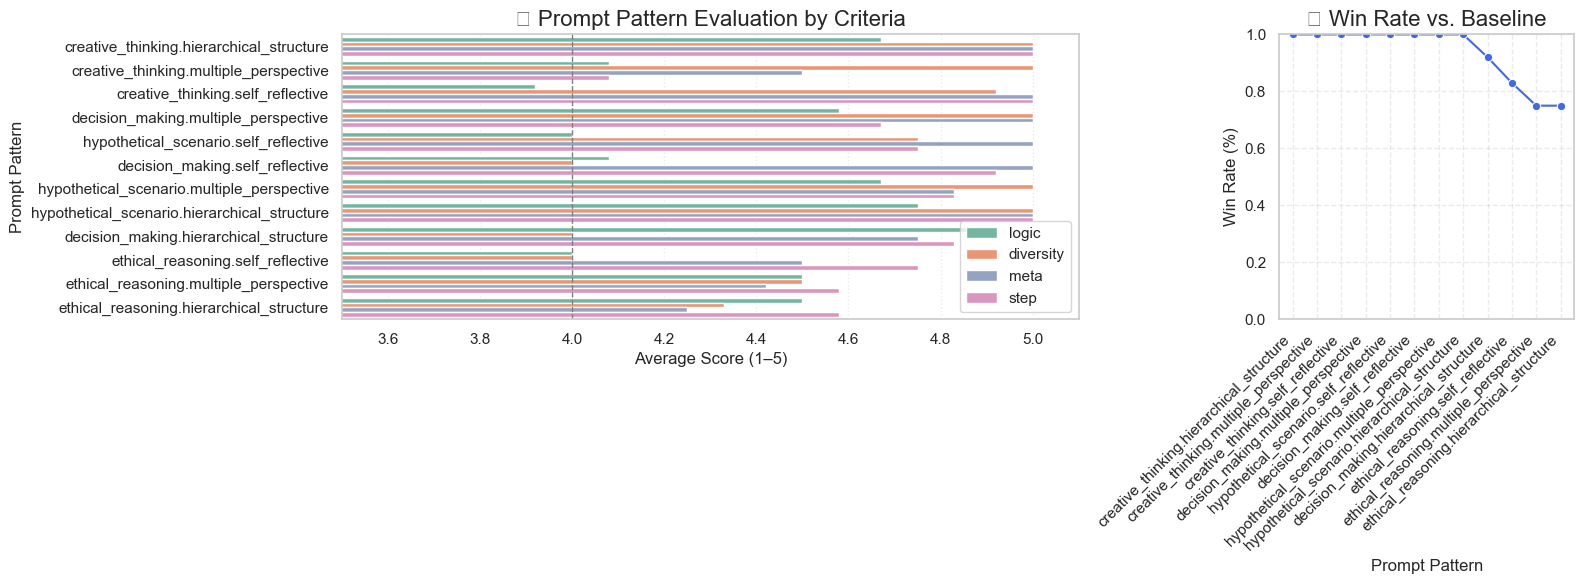

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 경로 주의 (VS Code에서는 상대 경로 OK)
df = pd.read_csv("./results/pairwise_judgment.csv")

# 평가 기준
score_cols = ["logic", "diversity", "meta", "step"]

# 평균 점수 계산
avg_scores = df.groupby("pattern")[score_cols].mean().round(2).reset_index()

# baseline 대비 우위 판단 횟수 계산
win_counts = df[df["better"] == "B"].groupby("pattern").size().reset_index(name="wins_vs_baseline")
total_counts = df.groupby("pattern").size().reset_index(name="total")

# 결합 및 win rate 계산
win_summary = pd.merge(avg_scores, win_counts, on="pattern", how="left").fillna(0)
win_summary = pd.merge(win_summary, total_counts, on="pattern", how="left")
win_summary["wins_vs_baseline"] = win_summary["wins_vs_baseline"].astype(int)
win_summary["win_rate"] = (win_summary["wins_vs_baseline"] / win_summary["total"]).round(2)

# 정렬
win_summary = win_summary.sort_values("win_rate", ascending=False)

# 스타일 설정
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# 서브플롯 구성
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={"width_ratios": [2.5, 1]})

# (1) 점수 막대그래프
melted = win_summary.melt(id_vars=["pattern"], value_vars=score_cols, 
                          var_name="Criterion", value_name="Average Score")

sns.barplot(data=melted, x="Average Score", y="pattern", hue="Criterion", ax=axes[0], palette="Set2")
axes[0].set_title("🧠 Prompt Pattern Evaluation by Criteria")
axes[0].set_xlim(3.5, 5.1)
axes[0].axvline(4.0, color="gray", linestyle="--", lw=1)
axes[0].set_xlabel("Average Score (1–5)")
axes[0].set_ylabel("Prompt Pattern")
axes[0].legend(loc='lower right')
axes[0].grid(axis="x", linestyle=":", alpha=0.4)

# (2) 승률 라인플롯
sns.lineplot(data=win_summary, x="pattern", y="win_rate", marker="o", ax=axes[1], color="royalblue")
axes[1].set_title("🏆 Win Rate vs. Baseline")
axes[1].set_ylim(0, 1.0)
axes[1].set_xticklabels(win_summary["pattern"], rotation=45, ha="right")
axes[1].set_ylabel("Win Rate (%)")
axes[1].set_xlabel("Prompt Pattern")
axes[1].grid(True, linestyle="--", alpha=0.4)

# 전체 레이아웃 및 저장
plt.tight_layout()
os.makedirs("results", exist_ok=True)
save_path = "results/prompt_pattern_combined_plot.png"
plt.savefig(save_path)
plt.show()


C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1352204960.py:55: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\phoot\AppData\Local\Temp\ipykernel_11716\1352204960.py:57: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.savefig("results/prompt_pattern_summary_final.png", dpi=300)
e:\KIICE\thought_simulator\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


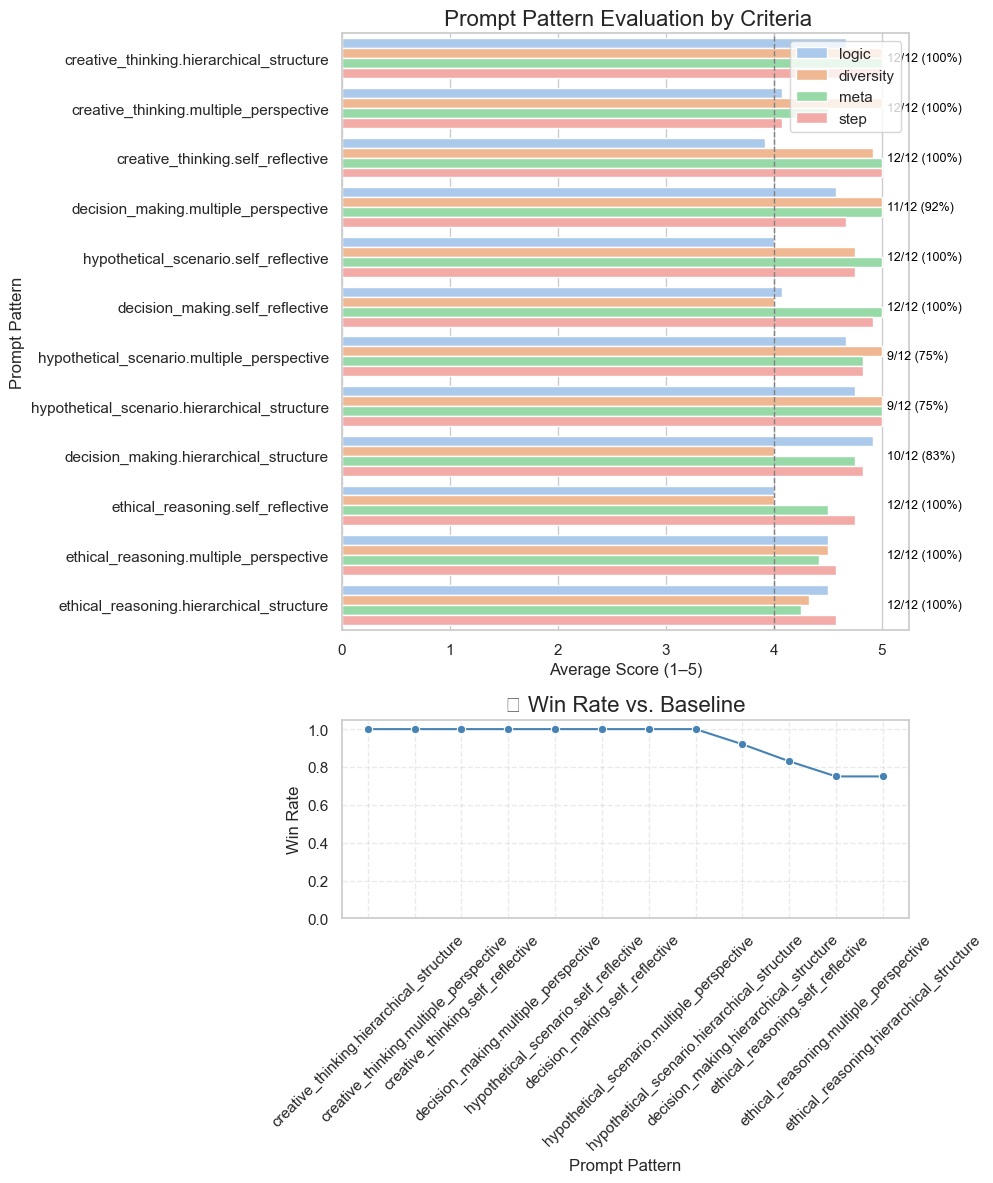

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 데이터 로딩
df = pd.read_csv("./results/pairwise_judgment.csv")
score_cols = ["logic", "diversity", "meta", "step"]

# 평균 점수 및 승률 계산
avg_scores = df.groupby("pattern")[score_cols].mean().round(2).reset_index()
win_counts = df[df["better"] == "B"].groupby("pattern").size().reset_index(name="wins_vs_baseline")
total_counts = df.groupby("pattern").size().reset_index(name="total")
summary = pd.merge(avg_scores, win_counts, on="pattern", how="left").fillna(0)
summary = pd.merge(summary, total_counts, on="pattern", how="left")
summary["wins_vs_baseline"] = summary["wins_vs_baseline"].astype(int)
summary["win_rate"] = (summary["wins_vs_baseline"] / summary["total"]).round(2)
summary = summary.sort_values("win_rate", ascending=False)

# 스타일 설정
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# 시각화용 데이터 정리
melted = summary.melt(id_vars=["pattern"], value_vars=score_cols, var_name="Criterion", value_name="Average Score")

# 그래프 생성
fig, axes = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={"height_ratios": [3, 1]})

# 1️⃣ 평균 점수 막대그래프 (상단)
sns.barplot(data=melted, x="Average Score", y="pattern", hue="Criterion", ax=axes[0], palette="pastel")
axes[0].axvline(4.0, linestyle="--", color="gray", lw=1)
axes[0].set_title(" Prompt Pattern Evaluation by Criteria")
axes[0].set_xlabel("Average Score (1–5)")
axes[0].set_ylabel("Prompt Pattern")
axes[0].legend(loc="upper right")

# 각 패턴마다 승률 텍스트 표시
for i, row in summary.iterrows():
    axes[0].text(5.05, i, f"{int(row['wins_vs_baseline'])}/{int(row['total'])} ({row['win_rate']*100:.0f}%)",
                 va="center", fontsize=9, color="black")

# 2️⃣ 승률 라인그래프 (하단)
sns.lineplot(data=summary, x="pattern", y="win_rate", marker="o", ax=axes[1], color="steelblue")
axes[1].set_title(" Win Rate vs. Baseline")
axes[1].set_ylabel("Win Rate")
axes[1].set_ylim(0, 1.05)
axes[1].set_xlabel("Prompt Pattern")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, linestyle="--", alpha=0.4)

# 저장
plt.tight_layout()
os.makedirs("results", exist_ok=True)
plt.savefig("results/prompt_pattern_summary_final.png", dpi=300)
plt.show()


In [54]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("./results/pairwise_judgment.csv")

# 평가 기준
score_cols = ["logic", "diversity", "meta", "step"]

# 각 패턴 별 평균 점수 계산
avg_scores = df.groupby("pattern")[score_cols].mean().round(2).reset_index()

# 승률 계산
win_counts = df[df["better"] == "B"].groupby("pattern").size().reset_index(name="wins_vs_baseline")
total_counts = df.groupby("pattern").size().reset_index(name="total")

# 통합
summary = avg_scores.merge(win_counts, on="pattern", how="left").merge(total_counts, on="pattern")
summary["wins_vs_baseline"] = summary["wins_vs_baseline"].fillna(0).astype(int)
summary["win_rate"] = (summary["wins_vs_baseline"] / summary["total"] * 100).round(0).astype(int)

# LaTeX 테이블 생성
latex_lines = [
    r"\begin{table}[ht]",
    r"\centering",
    r"\caption{Evaluation Results of Structured Prompt Patterns}",
    r"\label{tab:prompt_evaluation}",
    r"\begin{tabular}{lcccccc}",
    r"\toprule",
    r"\textbf{Prompt Pattern} & \textbf{Logic} & \textbf{Diversity} & \textbf{Meta} & \textbf{Step} & \textbf{Win Rate (\%)} & \textbf{Win / Total} \\",
    r"\midrule"
]

for _, row in summary.iterrows():
    pattern = row['pattern'].replace("_", r"\_")  # LaTeX 특수문자 escape
    logic, div, meta, step = row['logic'], row['diversity'], row['meta'], row['step']
    win_rate = row['win_rate']
    win_ratio = f"{row['wins_vs_baseline']}/{row['total']}"
    line = f"{pattern} & {logic} & {div} & {meta} & {step} & {win_rate} & {win_ratio} \\\\"
    latex_lines.append(line)

latex_lines.extend([
    r"\bottomrule",
    r"\end{tabular}",
    r"\end{table}"
])

# 결과 출력
latex_table = "\n".join(latex_lines)
print(latex_table)

# 필요시 저장
with open("./results/prompt_table.tex", "w", encoding="utf-8") as f:
    f.write(latex_table)


\begin{table}[ht]
\centering
\caption{Evaluation Results of Structured Prompt Patterns}
\label{tab:prompt_evaluation}
\begin{tabular}{lcccccc}
\toprule
\textbf{Prompt Pattern} & \textbf{Logic} & \textbf{Diversity} & \textbf{Meta} & \textbf{Step} & \textbf{Win Rate (\%)} & \textbf{Win / Total} \\
\midrule
creative\_thinking.hierarchical\_structure & 4.67 & 5.0 & 5.0 & 5.0 & 100 & 12/12 \\
creative\_thinking.multiple\_perspective & 4.08 & 5.0 & 4.5 & 4.08 & 100 & 12/12 \\
creative\_thinking.self\_reflective & 3.92 & 4.92 & 5.0 & 5.0 & 100 & 12/12 \\
decision\_making.hierarchical\_structure & 4.92 & 4.0 & 4.75 & 4.83 & 92 & 11/12 \\
decision\_making.multiple\_perspective & 4.58 & 5.0 & 5.0 & 4.67 & 100 & 12/12 \\
decision\_making.self\_reflective & 4.08 & 4.0 & 5.0 & 4.92 & 100 & 12/12 \\
ethical\_reasoning.hierarchical\_structure & 4.5 & 4.33 & 4.25 & 4.58 & 75 & 9/12 \\
ethical\_reasoning.multiple\_perspective & 4.5 & 4.5 & 4.42 & 4.58 & 75 & 9/12 \\
ethical\_reasoning.self\_reflective 

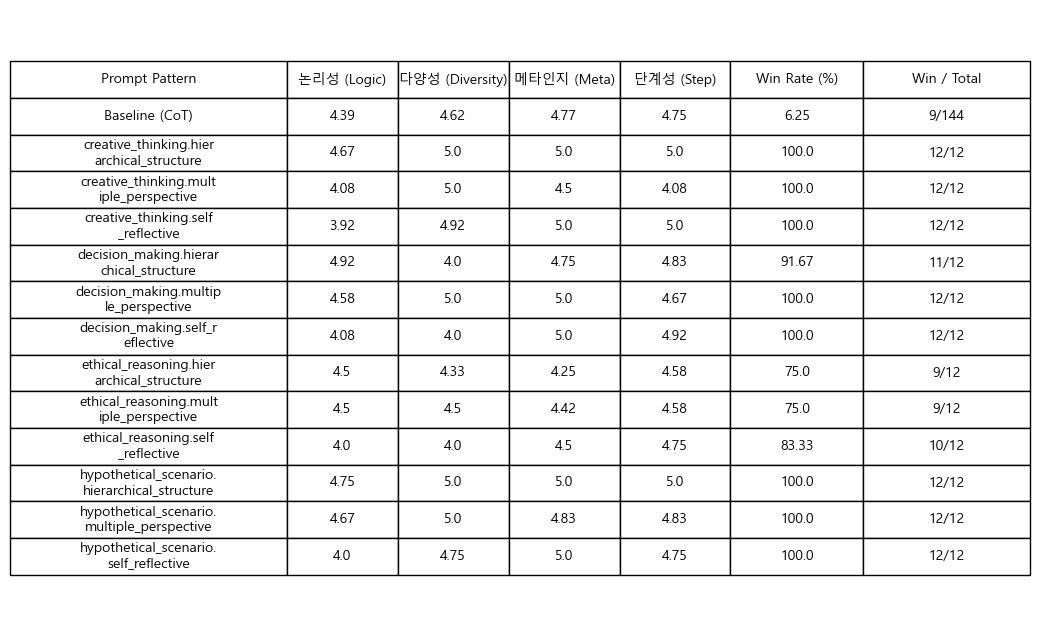

✅ 저장 완료: results/prompt_table_with_wrapped_labels.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import textwrap

# 📦 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("./results/pairwise_judgment.csv")
score_cols = ["logic", "diversity", "meta", "step"]

# 평균 점수 및 승률 계산
summary = df.groupby("pattern")[score_cols].mean().round(2).reset_index()
summary["Win Rate (%)"] = (
    df[df["better"] == "B"]
    .groupby("pattern")
    .size()
    .div(df.groupby("pattern").size())
    .mul(100)
    .round(2)
    .fillna(0)
    .values
)
summary["Win / Total"] = df.groupby("pattern")["better"].apply(
    lambda x: f"{(x == 'B').sum()}/{len(x)}"
).values

# 🔹 Baseline 계산
baseline_rows = df[df["A_name"] == "baseline_cot.hierarchical_structure"]
baseline_scores = baseline_rows[score_cols].mean().round(2)
baseline_win_count = (baseline_rows["better"] == "A").sum()
baseline_total = len(baseline_rows)
baseline_winrate = round(baseline_win_count / baseline_total * 100, 2) if baseline_total > 0 else 0

baseline_entry = {
    "Prompt Pattern": "Baseline (CoT)",
    "논리성 (Logic)": baseline_scores["logic"],
    "다양성 (Diversity)": baseline_scores["diversity"],
    "메타인지 (Meta)": baseline_scores["meta"],
    "단계성 (Step)": baseline_scores["step"],
    "Win Rate (%)": float(baseline_winrate),
    "Win / Total": f"{baseline_win_count}/{baseline_total}",
}

# 컬럼명 변경 및 결합
summary.columns = [
    "Prompt Pattern",
    "논리성 (Logic)",
    "다양성 (Diversity)",
    "메타인지 (Meta)",
    "단계성 (Step)",
    "Win Rate (%)",
    "Win / Total",
]
summary = pd.concat([pd.DataFrame([baseline_entry]), summary], ignore_index=True)

# 🎯 Prompt Pattern 줄바꿈 적용
summary["Prompt Pattern"] = summary["Prompt Pattern"].apply(
    lambda x: "\n".join(textwrap.wrap(x, width=22))
)

# 📐 표 시각화
fig, ax = plt.subplots(figsize=(13, 8))
ax.axis("off") 

table = plt.table(
    cellText=summary.values,
    colLabels=summary.columns,
    cellLoc="center",
    loc="center",
    colLoc="center",
    colWidths=[0.25, 0.1, 0.1, 0.1, 0.1, 0.12, 0.15],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 2.2)  # ⬅ row 높이 키움

# 저장
os.makedirs("results", exist_ok=True)
output_path = "results/prompt_table_with_wrapped_labels.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ 저장 완료: {output_path}")
